# LLM Generated Text Detection Using BERT

In this project, I will be focusing on the use of an NLP model called BERT and using it to detect artificially generated text vs. human-written text.

In [27]:
import numpy as np
import pandas as pd
train_essays = pd.read_csv("texts/train_essays.csv")
train_essays.head()

,id,prompt_id,text,generated
0,0059830c,0,Cars. Cars have been around since they became ...,0
1,005db917,0,Transportation is a large necessity in most co...,0
2,008f63e3,0,"""America's love affair with it's vehicles seem...",0
3,00940276,0,How often do you ride in a car? Do you drive a...,0
4,00c39458,0,Cars are a wonderful thing. They are perhaps o...,0


[Text(0, 0, '1375'), Text(0, 0, '3')]

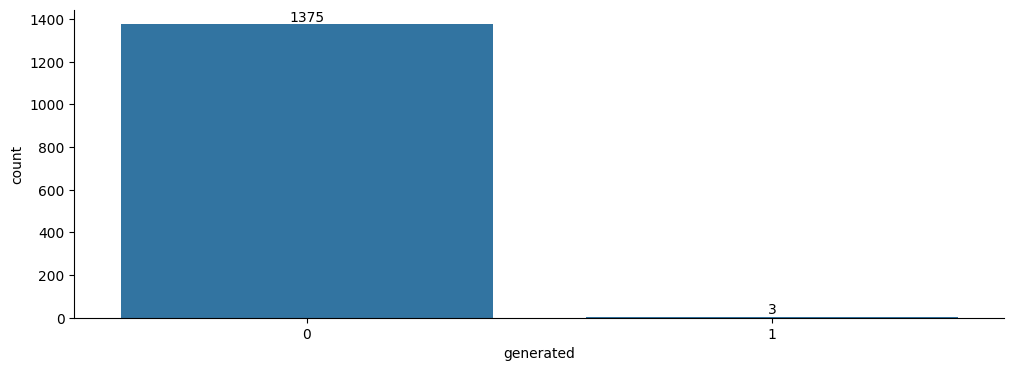

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt
f, a = plt.subplots(figsize=(12, 4))
sns.despine()
a = sns.countplot(data=train_essays, x="generated")
vals = train_essays['generated'].value_counts().values
a.bar_label(container=a.containers[0], labels=vals)

In [29]:
train_essays_ext = pd.read_csv('texts/external_dataset.csv')
train_essays_ext.rename(columns = {"label":"generated"}, inplace=True)
train_essays_ext.head()

,text,generated,prompt_name,source,RDizzl3_seven
0,Phones\n\nModern humans today are always on th...,0,Phones and driving,persuade_corpus,False
1,This essay will explain if drivers should or s...,0,Phones and driving,persuade_corpus,False
2,Driving while the use of cellular devices\n\nT...,0,Phones and driving,persuade_corpus,False
3,Phones & Driving\n\nDrivers should not be able...,0,Phones and driving,persuade_corpus,False
4,Cell Phone Operation While Driving\n\nThe abil...,0,Phones and driving,persuade_corpus,False


[Text(0, 0, '27371'), Text(0, 0, '17497')]

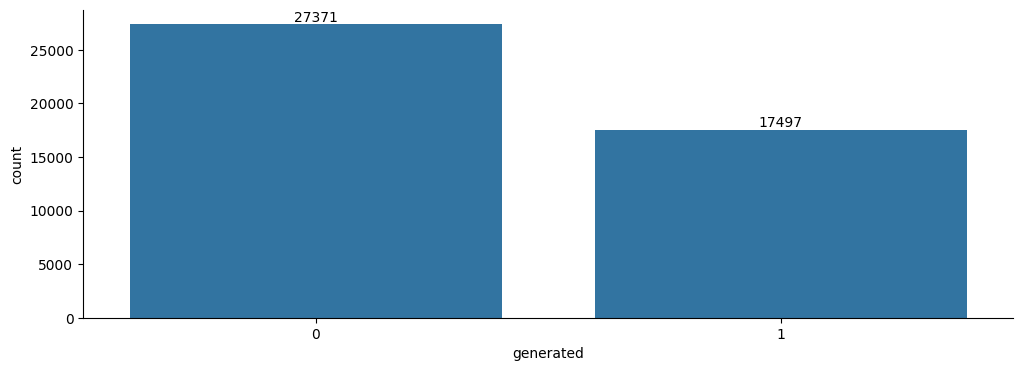

In [30]:
f, a = plt.subplots(figsize=(12, 4))
sns.despine()
a = sns.countplot(data=train_essays_ext, x="generated")
vals = train_essays_ext['generated'].value_counts().values
a.bar_label(container=a.containers[0], labels=vals)

In [31]:
train_essays_concat = pd.concat([train_essays_ext[["text", "generated"]], train_essays[["text", "generated"]]])

train_essays_concat

,text,generated
0,Phones\n\nModern humans today are always on th...,0
1,This essay will explain if drivers should or s...,0
2,Driving while the use of cellular devices\n\nT...,0
3,Phones & Driving\n\nDrivers should not be able...,0
4,Cell Phone Operation While Driving\n\nThe abil...,0
...,...,...
1373,There has been a fuss about the Elector Colleg...,0
1374,Limiting car usage has many advantages. Such a...,0
1375,There's a new trend that has been developing f...,0
1376,As we all know cars are a big part of our soci...,0


In [32]:
train_essays_concat["text_length"] = train_essays_concat["text"].apply(lambda x : len(x.split()))

<Figure size 2000x4000 with 0 Axes>

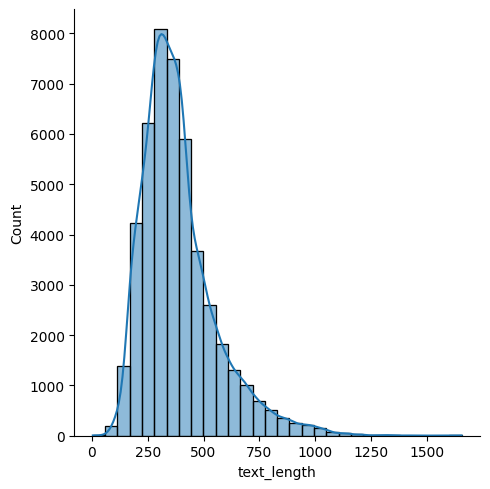

In [33]:
fig = plt.figure(figsize=(20,40))
plot = sns.displot(data=train_essays_concat,
                 x="text_length", bins=30, kde=True)

In [48]:
!pip install --upgrade keras

In [49]:
import tensorflow as tf
import keras
import keras_nlp
from keras.optimizers import Adam
# We choose 512 because it's the limit of DistilBert
SEQ_LENGTH = 512

# Use a shorter sequence length.
preprocessor = keras_nlp.models.DistilBertPreprocessor.from_preset(
    "distil_bert_base_en_uncased",
    sequence_length=SEQ_LENGTH,
)

# Pretrained classifier.
classifier = keras_nlp.models.DistilBertClassifier.from_preset(
    "distil_bert_base_en_uncased",
    num_classes=2,
    activation=None,
    preprocessor=preprocessor,
)

opt = Adam(0.0001)

# Re-compile (e.g., with a new learning rate)
classifier.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=opt,
    metrics=[
        keras.metrics.SparseCategoricalAccuracy()
   ]
)


# Access backbone programmatically (e.g., to change `trainable`).
classifier.backbone.trainable = False


classifier.summary()

ValueError: Unable to import `keras` with `tensorflow`.  Please check your Keras and Tensorflow version are compatible; Keras 3 requires TensorFlow 2.15 or later. See keras.io/getting_started for more information on installing Keras.

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_essays_concat["text"],
                                                    train_essays_concat["generated"],
                                                    test_size=0.33,
                                                    random_state=42)

In [ ]:
classifier.fit(x=X_train,
               y=y_train,
               validation_data=(X_test, y_test),
               epochs=1,
               batch_size=64
              )

 98/485 ━━━━━━━━━━━━━━━━━━━━ 11:49:37 110s/step - loss: 0.5265 - sparse_categorical_accuracy: 0.7489

In [ ]:
y_pred_test = classifier.predict(X_test)

477/477 ━━━━━━━━━━━━━━━━━━━━ 226s 469ms/step


In [ ]:
classifier.predict(["Amidst the tranquil stillness of the forest, a symphony of nature's melodies played out harmoniously. The gentle rustle of leaves overhead whispered secrets of the ancient trees, while the babbling brook nearby provided a soothing rhythm to the wilderness. Shafts of sunlight pierced through the dense canopy, illuminating patches of vibrant green moss and wildflowers that adorned the forest floor. In this haven of serenity, time seemed to stand still, allowing one to bask in the beauty and wonder of the natural world, a sanctuary for the soul amidst the chaos of the modern age."])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step


array([[-0.47988012,  0.46879005]], dtype=float32)

In [ ]:
classifier.predict(["I went to the park the other day. It was so fun! I can't believe I had so much fun in the park. The dogs were yapping and the birds were flapping. I played catch with all my friends and my dad was there too. My mom prepared food and put it in the picnic basket. At lunch time we all say down and ate together. We had such a jolly good time. I can't wait to go to the park again!"])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step


array([[ 0.71214044, -0.67182165]], dtype=float32)

In [ ]:
classifier.predict(["In the past few decades, the rapid advancement of technology has revolutionized the way humans communicate with one another. From the advent of the internet to the proliferation of smartphones and social media platforms, technology has not only facilitated communication but has also transformed its very nature. While these technological innovations have undoubtedly brought about numerous benefits, they have also raised concerns about their impact on human interaction and relationships. One of the most significant effects of technology on communication is its ability to transcend geographical barriers. With the click of a button, individuals can now connect with others across the globe instantaneously, fostering collaboration and exchange of ideas on an unprecedented scale. This newfound connectivity has facilitated the globalization of communication, enabling cross-cultural dialogue and understanding. Moreover, the rise of social media platforms has empowered individuals to share their thoughts, experiences, and perspectives with a diverse audience, amplifying voices that were once marginalized or silenced. However, the pervasive use of technology in communication has also led to some adverse consequences. One such concern is the erosion of face-to-face interaction in favor of digital communication channels. With the prevalence of texting, instant messaging, and social networking sites, many people have become accustomed to communicating through screens rather than engaging in real-life conversations. This shift has raised questions about the quality of interpersonal relationships in the digital age, as face-to-face interactions are often regarded as essential for building trust, empathy, and intimacy. Furthermore, the instantaneous nature of digital communication has given rise to a culture of immediacy and impatience. In today's fast-paced world, individuals expect instant responses to their messages, leading to feelings of frustration and anxiety when communication is delayed. This constant need for connectivity and instant gratification can take a toll on mental health, contributing to stress, burnout, and feelings of isolation. Moreover, the proliferation of technology has also brought about new challenges related to privacy and security. With the digitization of personal information and the collection of data by tech companies, concerns about data breaches, identity theft, and surveillance have become increasingly prevalent. The pervasiveness of social media has also raised issues surrounding online harassment, cyberbullying, and the spread of misinformation, further complicating the landscape of digital communication. Despite these challenges, it is essential to recognize the immense potential of technology to enhance human communication and connectivity. By leveraging technology responsibly and mindfully, we can harness its power to bridge divides, foster meaningful connections, and promote positive social change. Moreover, as technology continues to evolve, it is crucial to prioritize digital literacy and education to empower individuals to navigate the complexities of the digital world effectively. In conclusion, the impact of technology on human communication is profound and multifaceted. While technology has revolutionized the way we connect and communicate, it has also posed challenges that require careful consideration and mitigation. By fostering a balance between digital and face-to-face interactions, promoting digital literacy, and prioritizing ethical use of technology, we can harness its potential to enrich human communication and enhance the fabric of society."])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


array([[-1.3804015,  1.3618296]], dtype=float32)

In [ ]:
def displayConfusionMatrix(y_true, y_pred, dataset):
    disp = ConfusionMatrixDisplay.from_predictions(
        y_true,
        np.argmax(y_pred, axis=1),
        display_labels=["Not Generated","Generated"],
        cmap=plt.cm.Blues
    )

    tn, fp, fn, tp = confusion_matrix(y_true, np.argmax(y_pred, axis=1)).ravel()
    f1_score = tp / (tp+((fn+fp)/2))

    disp.ax_.set_title("Confusion Matrix on " + dataset + " Dataset -- F1 Score: " + str(f1_score.round(2)))

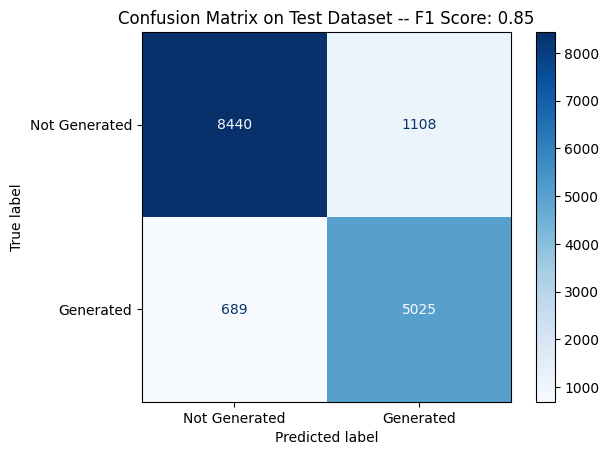

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
displayConfusionMatrix(y_test, y_pred_test,  "Test")